# DSBA MLNS: Kaggle Challenge - Link Prediction



ESSEC Business School and Centrale Supélec: DSBA 2023


Anmol KATIYAR	- anmol.katiyar@student-cs.fr <p>
Sarvani SAMBARAJU	- sarvani.sambaraju@student-cs.fr <p>
Yunjing JIANG	- yunjing.jiang@student-cs.fr <p>
Yunqiu Zhang	- yunqiu.zhang@student-cs.fr <p>


##Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MLNS/Kaggle/mlns-2023/

Mounted at /content/drive
/content/drive/MyDrive/MLNS/Kaggle/mlns-2023


In [ ]:
import os
import sys
import numpy as np 
import pandas as pd
import networkx as nx
import scipy
from tqdm import tqdm

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import xgboost

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [ ]:
!pip install catboost --quiet
from catboost import CatBoostClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.3 MB/s eta 0:00:00


##Creating Graph Features

In [ ]:
links = pd.read_csv('train.txt', header = None, sep = ' ', names = ['node', 'target', 'edge'])
X = links[['node', 'target']]
y = links['edge']

In [ ]:
def CreateGraph (X, y, directed = False):
    
    if directed:
        G = nx.from_pandas_edgelist(X, 'node', 'target', create_using=nx.DiGraph())
    else:    
        G = nx.from_pandas_edgelist(X[y == 1], 'node', 'target', create_using=nx.Graph())
        
    return G

In [ ]:
def AppendNextworkxFeature (function, X):
    
    column_name = str(function).split()[1]
    
    tuple_list = list(X[['node','target']].itertuples(index=False, name=None))
    coef_generator = function(G, tuple_list)
    coef_df = pd.DataFrame(coef_generator)
    X.insert(2, column_name, list(coef_df[2]), allow_duplicates = True)

In [ ]:
def katz_similarity(G, alpha=0.9, beta=0.3):
    A = nx.adjacency_matrix(G)
    I = np.identity(G.number_of_nodes())
    B = beta * A + I
    return np.linalg.inv(I - alpha * B) @ B

def pagerank_similarity(G):
    pr = nx.pagerank(G)
    pr_values = list(pr.values())
    pr_matrix = np.outer(pr_values, pr_values)
    return pr_matrix

In [ ]:
def finding_matrix(Matrix,N1,N2):
  R = nodes.index(N1)
  C = nodes.index(N2)
  return Matrix[R][C]

In [ ]:
def nxGenerateFeatures (X):
    
    # 1.3 Predict new coefficient/feature for defined link prediction function
    
    linkPredictionFunctions = [nx.resource_allocation_index, nx.preferential_attachment, nx.jaccard_coefficient] #, nx.adamic_adar_index, nx.preferential_attachment] , nx.jaccard_coefficient
    for function in linkPredictionFunctions:
        AppendNextworkxFeature(function,  X)

    X['KATZ'] = X.apply(lambda row: finding_matrix(KAT,row['node'],row['target']), axis = 1)
    X['PR'] = X.apply(lambda row: finding_matrix(PR,row['node'],row['target']), axis = 1)
    
    return X 

In [ ]:
G = CreateGraph (X, y)

In [ ]:
KAT = katz_similarity(G)

In [ ]:
PR = pagerank_similarity(G)

In [ ]:
nodes = list(G.nodes)

In [ ]:
scaler = StandardScaler()

In [ ]:
X = nxGenerateFeatures (X)

<ipython-input-13-5de8bcf20d50>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['KATZ'] = X.apply(lambda row: finding_matrix(KAT,row['node'],row['target']), axis = 1)
<ipython-input-13-5de8bcf20d50>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PR'] = X.apply(lambda row: finding_matrix(PR,row['node'],row['target']), axis = 1)


In [ ]:
X.head()

,node,target,jaccard_coefficient,preferential_attachment,resource_allocation_index,KATZ,PR
0,939,3809,0.00000,361,0.000000,-0.019993,3.900553e-06
1,2442,5784,0.10000,28,0.250000,1.142291,1.956352e-07
2,179,3809,0.00551,1444,0.285714,-0.007823,1.042680e-05
3,857,2280,0.00000,119,0.000000,-5.413160,7.025841e-07
4,1358,5722,0.00000,26,0.000000,-2.551858,2.023690e-07


## Generating Node Information Features

In [ ]:
def cosine_similarity_np(arr1, arr2):
    arr1 = np.array(arr1).reshape(1, -1)
    arr2 = np.array(arr2).reshape(1, -1)
    return cosine_similarity(arr1, arr2)[0][0]

def jaccard(im1, im2):
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
    intersection = np.logical_and(im1, im2)
    union = np.logical_or(im1, im2)
    return intersection.sum() / float(union.sum())


def hamming_distance(arr1, arr2):
    if arr1.shape != arr2.shape:
        raise ValueError("Arrays must have the same shape")  
    return np.sum(arr1 != arr2)

  

def nodeGenerateFeatures(X):
  X['node_mse'] = X.apply(lambda row: mean_squared_error(nodes_dict[row['node']],nodes_dict[row['target']]), axis = 1)
  X['node_cos'] = X.apply(lambda row: cosine_similarity_np(nodes_dict[row['node']],nodes_dict[row['target']]), axis = 1) 
  X['node_jacc'] = X.apply(lambda row: jaccard(nodes_dict[row['node']],nodes_dict[row['target']]), axis = 1) 
  X['node_map'] = X.apply(lambda row: mean_absolute_error(nodes_dict[row['node']],nodes_dict[row['target']]), axis = 1)
  X['node_meuc'] = X.apply(lambda row: euclidean(nodes_dict[row['node']].flatten(),nodes_dict[row['target']].flatten()), axis = 1)
  X['node_hamm'] = X.apply(lambda row: hamming_distance(nodes_dict[row['node']],nodes_dict[row['target']]), axis = 1)
  

  return X


In [ ]:
node_info = pd.read_csv('node_information.csv', header = None)
node_info.head()

,0,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nodes_dict = {}
for i in nodes:
  nodes_dict[i] = []

In [ ]:
for node in tqdm(nodes):
  l = node_info[node_info[0] == node] 
  for i in range(1,933):
    nodes_dict[node].append(l[i])


100%|██████████| 3597/3597 [01:54<00:00, 31.40it/s]


In [ ]:
for i in tqdm(nodes):
  nodes_dict[i] = np.array(nodes_dict[i])

100%|██████████| 3597/3597 [00:17<00:00, 200.06it/s]


In [ ]:
X = nodeGenerateFeatures(X)

<ipython-input-21-e2f13c9a6070>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['node_mse'] = X.apply(lambda row: mean_squared_error(nodes_dict[row['node']],nodes_dict[row['target']]), axis = 1)
<ipython-input-21-e2f13c9a6070>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['node_cos'] = X.apply(lambda row: cosine_similarity_np(nodes_dict[row['node']],nodes_dict[row['target']]), axis = 1)
<ipython-input-21-e2f13c9a6070>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [ ]:
X.head()

,node,target,jaccard_coefficient,preferential_attachment,resource_allocation_index,KATZ,PR,node_mse,node_cos,node_jacc,node_map,node_meuc,node_hamm
0,939,3809,0.00000,361,0.000000,-0.019993,3.900553e-06,0.009657,0.000000,0.000000,0.009657,3.000000,9
1,2442,5784,0.10000,28,0.250000,1.142291,1.956352e-07,0.009657,0.308607,0.181818,0.009657,3.000000,9
2,179,3809,0.00551,1444,0.285714,-0.007823,1.042680e-05,0.011803,0.000000,0.000000,0.011803,3.316625,11
3,857,2280,0.00000,119,0.000000,-5.413160,7.025841e-07,0.005365,0.000000,0.000000,0.005365,2.236068,5
4,1358,5722,0.00000,26,0.000000,-2.551858,2.023690e-07,0.010730,0.288675,0.166667,0.010730,3.162278,10


## Scaling Attributes

In [ ]:
scaler = StandardScaler()
cols = ['resource_allocation_index', 'preferential_attachment', 'jaccard_coefficient','KATZ','PR','node_mse','node_cos','node_jacc','node_map','node_meuc','node_hamm']
X[cols] = scaler.fit_transform(X[cols])

<ipython-input-29-1f70f10031d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cols] = scaler.fit_transform(X[cols])


## Feature Selection

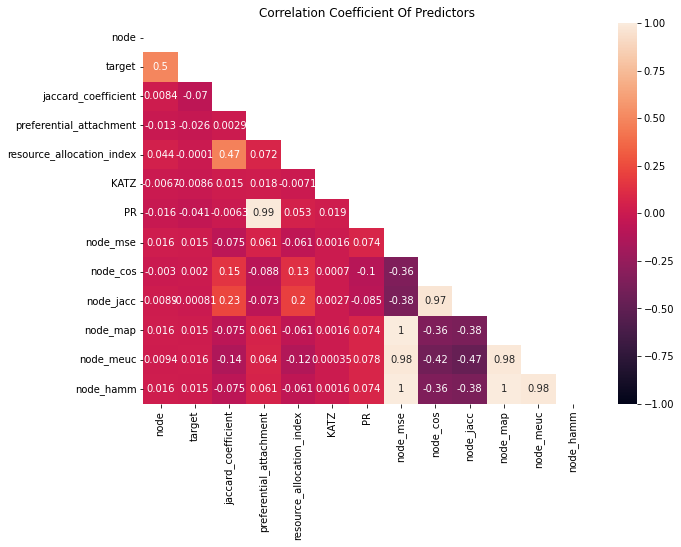

In [ ]:
plt.figure(figsize=(10,7))
mask = np.triu(np.ones_like(X.corr(), dtype=bool))

sns.heatmap(X.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()

In [ ]:
X = X.drop(columns=['KATZ','node_mse','node_hamm'],axis=1) #Dropping highly correlated features and KATZ is causing data leakage

In [ ]:
X.head()

,node,target,jaccard_coefficient,preferential_attachment,resource_allocation_index,PR,node_cos,node_jacc,node_map,node_meuc
0,939,3809,-0.138142,1.118547,-0.078171,1.711326,-0.842687,-0.719141,-0.033711,0.087242
1,2442,5784,1.428404,-0.111419,1.295865,-0.125857,0.780599,0.673581,-0.033711,0.087242
2,179,3809,-0.051830,5.118707,1.492156,4.947541,-0.842687,-0.719141,0.431242,0.527297
3,857,2280,-0.138142,0.224698,-0.078171,0.125527,-0.842687,-0.719141,-0.963617,-0.974496
4,1358,5722,-0.138142,-0.118807,-0.078171,-0.122518,0.675758,0.557521,0.198766,0.312781


## Test-Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=212)

# XGBoost Classifier Model

In [ ]:
def XGB(LR = 0.1, n_est = 1000, max_d = 5, min_c = 1, gm = 0, colsample = 0.8, subs = 1, lambd = 0, alpha = 0):
   
    xgb_model = XGBClassifier( learning_rate=LR, 
                                            n_estimators=n_est,
                                            max_depth=max_d,
                                            min_child_weight=min_c,                         
                                            gamma=gm,
                                            colsample_bytree=colsample,
                                            subsample=subs,
                                            objective ='binary:logistic',                   
                                            reg_lambda=lambd,
                                            reg_alpha=alpha,
                                            scale_pos_weight = 1,
                                            tree_method='gpu_hist',
                                            seed=42)


    xgb_model.fit(X_train,y_train)
    y_pred_train = xgb_model.predict(X_train)
    y_pred = xgb_model.predict(X_test)


    print('performance over the training set: ' + str(f1_score(y_train, y_pred_train)))
    print('performance over the test set: ' + str(f1_score(y_test, y_pred)) + '\n')
    print(classification_report(y_test, y_pred))
    
    
    
def XGB_tuning (LR = 0.1, n_est = 1000, max_d = 5, min_c = 1, gm = 0, colsample = 0.8, subs = 1,
                lambd = 0, alpha = 0, param_test = {'learning_rate':[i/100.0 for i in range(5,20,2)]} ):
    
    gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate=LR, 
                                                    n_estimators=n_est,
                                                    max_depth=max_d,
                                                    min_child_weight=min_c,                         
                                                    gamma=gm,
                                                    colsample_bytree=colsample,
                                                    subsample = subs,
                                                    objective ='binary:logistic',
                                                    reg_lambda=lambd,
                                                    reg_alpha=alpha,
                                                    scale_pos_weight = 1,
                                                    tree_method='gpu_hist',
                                                    seed=42), 
                            param_grid = param_test, 
                            scoring='f1',
                            n_jobs=4, 
                            cv=3)


    gsearch.fit(X_train, y_train)
    return gsearch

In [ ]:
# STEP 1 - First XGB - A little bit overfitted, but could improve more the training set
LearningRate = 0.1
n_estimators = 1000

# Fix Learning Rate and n_estimators
XGB(LearningRate, n_estimators)

performance over the training set: 0.9861292234736219
performance over the test set: 0.7322297955209347

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      1083
           1       0.73      0.74      0.73      1017

    accuracy                           0.74      2100
   macro avg       0.74      0.74      0.74      2100
weighted avg       0.74      0.74      0.74      2100



In [ ]:
# STEP 2 - Tuning max_depth and min_child_weight

parameters_test = {
    'max_depth':range(3,7,2),
    'min_child_weight':range(1,7,2)
}

gsearch2 = XGB_tuning (LR = LearningRate, n_est = n_estimators, param_test=parameters_test)
best_max_depth, best_min_child_weight = gsearch2.best_params_['max_depth'], gsearch2.best_params_['min_child_weight']
print(f"{gsearch2.best_params_} CV_Score: {gsearch2.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d=best_max_depth, min_c= best_min_child_weight)

{'max_depth': 3, 'min_child_weight': 5} CV_Score: 0.7516959596022531
performance over the training set: 0.8426873749852923
performance over the test set: 0.7416058394160584

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1083
           1       0.73      0.75      0.74      1017

    accuracy                           0.75      2100
   macro avg       0.75      0.75      0.75      2100
weighted avg       0.75      0.75      0.75      2100



In [ ]:
# STEP 3 - Tuning Gamma 
parameters_test = { 
    'gamma':[i/10.0 for i in range(0,5)] 
}

gsearch3 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d=best_max_depth, min_c= best_min_child_weight,
                      param_test=parameters_test)
best_gamma = gsearch3.best_params_['gamma']
print(f"{gsearch3.best_params_} CV_Score: {gsearch3.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight, gm = best_gamma)

{'gamma': 0.4} CV_Score: 0.7645475134652827
performance over the training set: 0.7941826643397324
performance over the test set: 0.7565758010521282

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1083
           1       0.74      0.78      0.76      1017

    accuracy                           0.76      2100
   macro avg       0.76      0.76      0.76      2100
weighted avg       0.76      0.76      0.76      2100



In [ ]:
# STEP 4 - Tuning colsample_bytree and subsaample
parameters_test = {
    'colsample_bytree':[i/10.0 for i in range(7,11)],
    'subsample':[i/10.0 for i in range(7,11)]
}

gsearch4 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                      gm = best_gamma, param_test=parameters_test)
best_colsample_bytree, best_subsample = gsearch4.best_params_['colsample_bytree'], gsearch4.best_params_['subsample']
print(f"{gsearch4.best_params_} CV_Score: {gsearch4.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, 
                       min_c = best_min_child_weight, gm = best_gamma,  colsample = best_colsample_bytree, 
                       subs = best_subsample)

{'colsample_bytree': 0.9, 'subsample': 1.0} CV_Score: 0.7656482550206998
performance over the training set: 0.7921138590760616
performance over the test set: 0.7580258744609487

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1083
           1       0.74      0.78      0.76      1017

    accuracy                           0.76      2100
   macro avg       0.76      0.76      0.76      2100
weighted avg       0.76      0.76      0.76      2100



In [ ]:
# STEP 5 - Tuning Regularization Parameters
# Lambda L2 Regularization
# Ampha L1 Regularization

parameters_test = {
    'reg_lambda':[1e-2, 0.1, 0.5, 1, 2, 10],
    'reg_alpha':[1e-2, 0.1, 0.5, 1, 2, 10],
}

gsearch5 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, 
                       min_c = best_min_child_weight, gm = best_gamma,  colsample = best_colsample_bytree, 
                       subs = best_subsample, param_test=parameters_test)

best_reg_lambda, best_reg_alpha = gsearch5.best_params_['reg_lambda'], gsearch5.best_params_['reg_alpha']
print(f"{gsearch5.best_params_} CV_Score: {gsearch5.best_score_}")

{'reg_alpha': 0.01, 'reg_lambda': 0.01} CV_Score: 0.7673459568372266


In [ ]:
# Closer Look
parameters_test = {
    'reg_lambda':[best_reg_lambda*0.8, best_reg_lambda, best_reg_lambda*1.2, best_reg_lambda*1.5],
    'reg_alpha':[best_reg_alpha*0.8, best_reg_alpha, best_reg_alpha*1.2, best_reg_alpha*1.5]
}

gsearch5 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       param_test=parameters_test)

best_reg_lambda, best_red_alpha = gsearch5.best_params_['reg_lambda'], gsearch5.best_params_['reg_alpha']
print(f"{gsearch5.best_params_} CV_Score: {gsearch5.best_score_}")

# Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       lambd = best_reg_lambda, alpha = best_reg_alpha)

{'reg_alpha': 0.012, 'reg_lambda': 0.012} CV_Score: 0.7690354582803717
performance over the training set: 0.7889225040726088
performance over the test set: 0.7505983724269986

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1083
           1       0.73      0.77      0.75      1017

    accuracy                           0.75      2100
   macro avg       0.75      0.75      0.75      2100
weighted avg       0.75      0.75      0.75      2100



In [ ]:
 # STEP 6 - Reducing Learning Rate and Adding More Trees
n_estimators = 10000
parameters_test = {
    'learning_rate':[i/100.0 for i in range(1,10)]
}

gsearch6 = XGB_tuning (LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       lambd = best_reg_lambda, alpha = best_reg_alpha, param_test=parameters_test)

LearningRate = gsearch6.best_params_['learning_rate']
print(f"{gsearch6.best_params_} CV_Score: {gsearch6.best_score_}")


# Final Evaluation
XGB(LR = LearningRate, n_est = n_estimators, max_d = best_max_depth, min_c = best_min_child_weight,
                       gm = best_gamma,  colsample = best_colsample_bytree, subs = best_subsample, 
                       lambd = best_reg_lambda, alpha = best_reg_alpha)

{'learning_rate': 0.02} CV_Score: 0.7688524771551184
performance over the training set: 0.7886140923938405
performance over the test set: 0.7564717162032599

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1083
           1       0.74      0.78      0.76      1017

    accuracy                           0.76      2100
   macro avg       0.76      0.76      0.76      2100
weighted avg       0.76      0.76      0.76      2100



# CAT Boost


In [ ]:
CBC = CatBoostClassifier()

In [ ]:
param_grid = {
              'learning_rate': [i/100 for i in range(4,10)],
              'depth': [3,4,5],
              'l2_leaf_reg': [0,4,5,6],              
              'boosting_type': ['Plain'],
              'bootstrap_type': ['MVS'],
              'grow_policy': ['SymmetricTree']}


In [ ]:
results = CBC.grid_search(param_grid,
            X,
            y,
            cv=3,
            partition_random_seed=44,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=True,
            train_size=0.8,
            verbose=True,
            plot=False,
            log_cout=sys.stdout,
            log_cerr=sys.stderr)


Streaming output truncated to the last 5000 lines.
26:	learn: 0.4555725	test: 0.4539928	best: 0.4539928 (26)	total: 80.9ms	remaining: 2.92s
27:	learn: 0.4549385	test: 0.4534642	best: 0.4534642 (27)	total: 83.9ms	remaining: 2.91s
28:	learn: 0.4540121	test: 0.4524714	best: 0.4524714 (28)	total: 87.5ms	remaining: 2.93s
29:	learn: 0.4516873	test: 0.4503915	best: 0.4503915 (29)	total: 94.3ms	remaining: 3.05s
30:	learn: 0.4510328	test: 0.4499360	best: 0.4499360 (30)	total: 99.1ms	remaining: 3.1s
31:	learn: 0.4506809	test: 0.4495779	best: 0.4495779 (31)	total: 102ms	remaining: 3.1s
32:	learn: 0.4490404	test: 0.4479847	best: 0.4479847 (32)	total: 106ms	remaining: 3.12s
33:	learn: 0.4474713	test: 0.4467830	best: 0.4467830 (33)	total: 110ms	remaining: 3.11s
34:	learn: 0.4472468	test: 0.4466755	best: 0.4466755 (34)	total: 113ms	remaining: 3.1s
35:	learn: 0.4466735	test: 0.4458610	best: 0.4458610 (35)	total: 116ms	remaining: 3.1s
36:	learn: 0.4462521	test: 0.4456672	best: 0.4456672 (36)	total: 119

In [ ]:
CBC.get_params()

{'depth': 4,
 'l2_leaf_reg': 4,
 'learning_rate': 0.04,
 'grow_policy': 'SymmetricTree',
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS'}

## Submission Prediction

In [ ]:
X_submission = pd.read_csv('test.txt', header = None, sep = ' ', names = ['node', 'target'])

In [ ]:
X_submission = nxGenerateFeatures(X_submission)
X_submission = nodeGenerateFeatures(X_submission)

In [ ]:
X_submission[cols] = scaler.transform(X_submission[cols])

In [ ]:
X_submission = X_submission.drop(columns=['KATZ','node_mse','node_hamm'],axis=1)

In [ ]:
X_submission.head()

,node,target,jaccard_coefficient,preferential_attachment,resource_allocation_index,PR,node_cos,node_jacc,node_map,node_meuc
0,3425,4524,-0.138142,-0.207453,-0.078171,-0.209646,0.231016,0.131967,-0.266187,-0.151216
1,1620,2617,-0.138142,-0.200066,-0.078171,-0.202134,-0.842687,-0.719141,-0.498664,-0.405105
2,4832,6317,-0.138142,-0.207453,-0.078171,-0.205996,0.117662,-0.080810,0.431242,0.527297
3,4984,7298,-0.138142,-0.200066,-0.078171,-0.201603,1.636924,1.637773,-0.033711,0.087242
4,385,5481,-0.138142,-0.207453,-0.078171,-0.213195,1.017021,0.812853,-1.196094,-1.302592


In [ ]:
param = { 'learning_rate': LearningRate, 
                'n_estimators': n_estimators,
                'max_depth': best_max_depth,
                'min_child_weight': best_min_child_weight,                         
                'gamma': best_gamma,
                'colsample_bytree': best_colsample_bytree,
                'subsample': best_subsample,
                'objective': 'binary:logistic',                   
                'reg_lambda': best_reg_lambda,
                'reg_alpha': best_reg_alpha,
                'scale_pos_weight': 1,
                'tree_method': 'gpu_hist',
                'seed': 42}

xgb_final_model = XGBClassifier(**param)


xgb_final_model.fit(X,y)
y_pred_xg = xgb_final_model.predict(X_submission)
y_pred_xg = y_pred_xg.astype(int)

In [ ]:
y_pred_cat = CBC.predict(X_submission)

In [ ]:
# Save XG Results
result_file_name = 'prediction_trial_13_XG.csv'
pd.DataFrame(y_pred_xg, columns = ['Predicted']).to_csv(result_file_name, sep=',', index=True, index_label='ID')

In [ ]:
# Save CAT Results
result_file_name = 'prediction_trial_13_CAT.csv'
pd.DataFrame(y_pred_cat, columns = ['Predicted']).to_csv(result_file_name, sep=',', index=True, index_label='ID')